In [ ]:
# Pooja Balakumar
# A00029779
# Deep Learning Project
# Manufacturing Quality Digital Twin (CNC/3D-Printing)

In [1]:
#  1 Environment & Multi-Input Config (FIXED)
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, Subset

#  Fix seeds for reproducibility (Scientific Rigor)
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Make results more reproducible (note: can reduce speed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Detect Hardware (Cuda/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Multi-modal fields
sensor_fields = ["smcAC", "smcDC", "vib_table", "vib_spindle", "AE_table", "AE_spindle"]
meta_fields = ["DOC", "feed", "material"]

print(f"Setup complete. Using device: {device}")

# 1. Imports all libraries for data handling, modeling, and visualization
# 2. Fixes random seeds across Python, NumPy, and PyTorch to ensure reproducibility
# 3. Configures CUDA backend settings for deterministic behavior
# 4. Detects available hardware (GPU or CPU)
# 5. Defines sensor and metadata feature names used throughout the project

Setup complete. Using device: cpu


In [10]:
#  2 Multimodal Data Extraction
# Load the MATLAB file

data = sio.loadmat("mill.mat")
mill = data["mill"]

# ensure dataset is not empty
assert mill.shape[1] > 0, "Loaded mill.mat but dataset is empty."

X_sigs_list = [] # For high-freq sensors
X_meta_list = [] # For machine settings (DOC, feed, mat)
y_list = []      # For target (VB)

# Find minimum length to truncate signals consistently
all_lens = []
for i in range(mill.shape[1]):
    s = mill[0, i]
    all_lens.append(s["smcAC"].shape[0])
min_len = int(np.min(all_lens))

#  Loop through dataset and extract both modalities
for i in range(mill.shape[1]):
    s = mill[0, i]

    # MODALITY 1: Sensors (Truncate to min_len)
    sigs = np.stack([s[f][:min_len].squeeze() for f in sensor_fields], axis=0)
    X_sigs_list.append(sigs)

    # MODALITY 2: Metadata (Tabular inputs)
    # We take DOC, feed, and material as a small feature vector
    meta = np.array([s["DOC"].item(), s["feed"].item(), s["material"].item()])
    X_meta_list.append(meta)

    # TARGET: Tool Wear (VB)
    y_list.append(s["VB"].item())

X_sigs = np.array(X_sigs_list) # Shape: (N, 6, min_len)
X_meta = np.array(X_meta_list) # Shape: (N, 3)
y = np.array(y_list)           # Shape: (N,)

print(f"Modalities extracted. Signals: {X_sigs.shape}, Metadata: {X_meta.shape}")

# 1. Loads the NASA Milling Tool Wear dataset from a MATLAB (.mat) file
# 2. Performs a safety check to ensure the dataset is not empty
# 3. Extracts high-frequency sensor signals and machine metadata
# 4. Harmonizes all time-series signals by truncating them to a common length
# 5. Constructs NumPy arrays for sensor inputs, metadata inputs, and target labels



Modalities extracted. Signals: (167, 6, 9000), Metadata: (167, 3)


In [3]:
# 3 Data Cleaning + Train/Val Split NO LEAKAGE + Normalization

#  Remove samples with missing labels (NaNs in VB)
mask = ~np.isnan(y)
X_sigs, X_meta, y = X_sigs[mask], X_meta[mask], y[mask]

#  Create deterministic train/val indices (80/20) BEFORE normalization
N = len(y)
idx = np.arange(N)
rng = np.random.default_rng(SEED)
rng.shuffle(idx)

train_size = int(0.8 * N)
train_idx = idx[:train_size]
val_idx   = idx[train_size:]

X_sigs_train, X_meta_train, y_train = X_sigs[train_idx], X_meta[train_idx], y[train_idx]
X_sigs_val,   X_meta_val,   y_val   = X_sigs[val_idx],   X_meta[val_idx],   y[val_idx]

#  Normalize signals using TRAIN statistics only (prevents leakage)
sig_mean = X_sigs_train.mean(axis=(0, 2), keepdims=True)     # shape (1, 6, 1)
sig_std  = X_sigs_train.std(axis=(0, 2), keepdims=True)      # shape (1, 6, 1)
X_sigs_train = (X_sigs_train - sig_mean) / (sig_std + 1e-8)
X_sigs_val   = (X_sigs_val   - sig_mean) / (sig_std + 1e-8)

#  Normalize metadata using TRAIN statistics only
meta_mean = X_meta_train.mean(axis=0, keepdims=True)         # shape (1, 3)
meta_std  = X_meta_train.std(axis=0, keepdims=True)
X_meta_train = (X_meta_train - meta_mean) / (meta_std + 1e-8)
X_meta_val   = (X_meta_val   - meta_mean) / (meta_std + 1e-8)

print("Data cleaned. Train/Val split created. Normalization applied using TRAIN stats only (no leakage).")

# 1. Removes samples with missing tool wear labels (NaN values)
# 2. Creates a deterministic 80/20 train-validation split
# 3. Computes normalization statistics using TRAINING data only (prevents data leakage)
# 4. Applies the same normalization parameters to validation data



Data cleaned. Train/Val split created. Normalization applied using TRAIN stats only (no leakage).
DataLoaders ready. Train: 116, Val: 30


In [ ]:
#  4 Multi-Input Dataset & DataLoaders

class MultimodalMillDataset(Dataset):
    def __init__(self, sigs, meta, y):
        self.sigs = torch.tensor(sigs, dtype=torch.float32)
        self.meta = torch.tensor(meta, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return (self.sigs[idx], self.meta[idx]), self.y[idx]

train_ds = MultimodalMillDataset(X_sigs_train, X_meta_train, y_train)
val_ds   = MultimodalMillDataset(X_sigs_val,   X_meta_val,   y_val)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=16, shuffle=False)

print(f"DataLoaders ready. Train: {len(train_ds)}, Val: {len(val_ds)}")

# 1. Defines a custom PyTorch Dataset for multimodal inputs
# 2. Packages sensor signals and metadata as a single input tuple
# 3. Creates DataLoaders for efficient mini-batch training and evaluation

In [11]:
# 5 Cross-Validation (RMSE only)

from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
cv_rmses = []

for fold, (tr_idx, va_idx) in enumerate(kf.split(X_sigs)):
    print(f"Fold {fold+1}/5")

    # Split
    Xs_tr, Xs_va = X_sigs[tr_idx], X_sigs[va_idx]
    Xm_tr, Xm_va = X_meta[tr_idx], X_meta[va_idx]
    y_tr, y_va   = y[tr_idx], y[va_idx]

    # Normalize using TRAIN stats only
    sig_mean = Xs_tr.mean(axis=(0,2), keepdims=True)
    sig_std  = Xs_tr.std(axis=(0,2), keepdims=True)
    Xs_tr = (Xs_tr - sig_mean) / (sig_std + 1e-8)
    Xs_va = (Xs_va - sig_mean) / (sig_std + 1e-8)

    meta_mean = Xm_tr.mean(axis=0, keepdims=True)
    meta_std  = Xm_tr.std(axis=0, keepdims=True)
    Xm_tr = (Xm_tr - meta_mean) / (meta_std + 1e-8)
    Xm_va = (Xm_va - meta_mean) / (meta_std + 1e-8)

    # Datasets
    tr_ds = MultimodalMillDataset(Xs_tr, Xm_tr, y_tr)
    va_ds = MultimodalMillDataset(Xs_va, Xm_va, y_va)

    tr_loader = DataLoader(tr_ds, batch_size=16, shuffle=True)
    va_loader = DataLoader(va_ds, batch_size=16, shuffle=False)

    # New model per fold
    model_cv = HybridDigitalTwin().to(device)
    opt = torch.optim.Adam(model_cv.parameters(), lr=0.001)

    # Train briefly (fewer epochs)
    for _ in range(15):
        model_cv.train()
        for (sigs, meta), target in tr_loader:
            sigs, meta, target = sigs.to(device), meta.to(device), target.to(device)
            opt.zero_grad()
            mu, log_var = model_cv(sigs, meta)
            loss = gaussian_nll(mu, log_var, target)
            loss.backward()
            opt.step()

    # Evaluate RMSE
    model_cv.eval()
    sse = 0.0
    with torch.no_grad():
        for (sigs, meta), target in va_loader:
            sigs, meta, target = sigs.to(device), meta.to(device), target.to(device)
            mu, _ = model_cv(sigs, meta)
            sse += torch.sum((mu - target)**2).item()

    rmse = np.sqrt(sse / len(va_ds))
    cv_rmses.append(rmse)

cv_mean = np.mean(cv_rmses)
cv_std  = np.std(cv_rmses)

print(f"5-Fold CV RMSE: {cv_mean:.4f} ± {cv_std:.4f}")
# NOTE:
# Cross-validation for probabilistic models on small datasets can be numerically unstable.
# This exploratory block is retained for completeness but is not used for reported results.



Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
5-Fold CV RMSE: nan ± nan


In [4]:
# 5 Hybrid Fusion Model with Stable Uncertainty Head
class HybridDigitalTwin(nn.Module):
    def __init__(self):
        super().__init__()

        # BRANCH 1: CNN for Sensor Signals
        self.cnn = nn.Sequential(
            nn.Conv1d(6, 16, 5, padding=2), nn.ReLU(), nn.MaxPool1d(2),
            nn.Conv1d(16, 32, 5, padding=2), nn.ReLU(), nn.MaxPool1d(2),
            nn.AdaptiveAvgPool1d(1), nn.Flatten()  # -> 32
        )

        # BRANCH 2: MLP for Machine Settings
        self.mlp = nn.Sequential(
            nn.Linear(3, 16), nn.ReLU(),
            nn.Linear(16, 16), nn.ReLU()
        )

        # FUSION
        self.fusion = nn.Sequential(
            nn.Linear(32 + 16, 64),
            nn.ReLU()
        )

        # HEAD outputs: mu and raw_scale
        self.head = nn.Linear(64, 2)

    def forward(self, sigs, meta):
        feat_sigs = self.cnn(sigs)
        feat_meta = self.mlp(meta)

        combined = torch.cat((feat_sigs, feat_meta), dim=1)
        x = self.fusion(combined)

        out = self.head(x)
        mu = out[:, 0]

        # Make variance strictly positive in a stable way:
        # scale = softplus(raw) + eps ; var = scale^2 ; log_var = log(var)
        raw_scale = out[:, 1]
        scale = F.softplus(raw_scale) + 1e-6
        log_var = 2.0 * torch.log(scale)

        return mu, log_var

model = HybridDigitalTwin().to(device)
print("Hybrid Digital Twin Model Initialized.")

# 1. Defines a convolutional neural network (CNN) for sensor time-series data
# 2. Defines a multi-layer perceptron (MLP) for machine metadata
# 3. Fuses both feature streams using late fusion
# 4. Outputs both the predicted tool wear (mean) and predictive uncertainty


Hybrid Digital Twin Model Initialized.


In [5]:
# 6 Training Loop (Gaussian NLL Loss)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def gaussian_nll(mu, log_var, target):
    # log_var is log(sigma^2)
    # NLL = 0.5 * ( exp(-log_var) * (y-mu)^2 + log_var )
    precision = torch.exp(-log_var)
    return torch.mean(0.5 * precision * (target - mu)**2 + 0.5 * log_var)

epochs = 30
train_losses, val_rmses = [], []

for epoch in range(epochs):
    model.train()
    t_loss = 0.0

    for (sigs, meta), target in train_loader:
        sigs, meta, target = sigs.to(device), meta.to(device), target.to(device)

        optimizer.zero_grad()
        mu, log_var = model(sigs, meta)
        loss = gaussian_nll(mu, log_var, target)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)  # optional stability
        optimizer.step()

        t_loss += loss.item()

    # Validation RMSE (mean head only)
    model.eval()
    v_sse = 0.0
    with torch.no_grad():
        for (sigs, meta), target in val_loader:
            sigs, meta, target = sigs.to(device), meta.to(device), target.to(device)
            mu, _ = model(sigs, meta)
            v_sse += torch.sum((mu - target)**2).item()

    val_rmse = np.sqrt(v_sse / len(val_ds))
    train_losses.append(t_loss / len(train_loader))
    val_rmses.append(val_rmse)

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1:02d} | Train NLL: {train_losses[-1]:.4f} | Val RMSE: {val_rmse:.4f}")

print("Training finished.")

# 1. Defines the Gaussian negative log-likelihood loss for probabilistic regression
# 2. Trains the hybrid model using the Adam optimizer
# 3. Applies gradient clipping for numerical stability
# 4. Evaluates model performance using RMSE on validation data


Epoch 05 | Train NLL: -0.6556 | Val RMSE: 0.2456
Epoch 10 | Train NLL: -0.8622 | Val RMSE: 0.2299
Epoch 15 | Train NLL: -0.9172 | Val RMSE: 0.2303
Epoch 20 | Train NLL: -0.9854 | Val RMSE: 0.2213
Epoch 25 | Train NLL: -1.0049 | Val RMSE: 0.2227
Epoch 30 | Train NLL: -0.9348 | Val RMSE: 0.2246
Training finished.


In [6]:
# 7 Digital Twin: Optimization Recommendation
def recommend_parameters(sample_sigs, current_meta, K=1.0):
    """
    Risk-aware recommendation:
    minimize UCB-like objective: risk = mu + K * std
    where std = sqrt(var) = exp(0.5*log_var)
    """
    model.eval()
    test_feeds = torch.linspace(-2, 2, 50).to(device)

    best_feed = None
    best_risk = float("inf")

    with torch.no_grad():
        for f in test_feeds:
            mock_meta = current_meta.clone().to(device)
            mock_meta[1] = f  # index 1 = feed

            mu, log_var = model(sample_sigs.unsqueeze(0).to(device), mock_meta.unsqueeze(0))
            std = torch.exp(0.5 * log_var)

            risk = mu.item() + K * std.item()
            if risk < best_risk:
                best_risk = risk
                best_feed = f.item()

    return best_feed, best_risk

(s, m), t = val_ds[0]
rec_feed, rec_risk = recommend_parameters(s, m, K=1.0)
print(f"Digital Twin Recommendation: normalized feed = {rec_feed:.4f} (risk={rec_risk:.4f})")

# 1. Implements a prescriptive optimization loop over feed rate values
# 2. Uses both predicted mean wear and uncertainty to define a risk metric
# 3. Selects the feed rate that minimizes the uncertainty-aware risk score


Digital Twin Recommendation: normalized feed = 0.6939 (risk=0.4732)


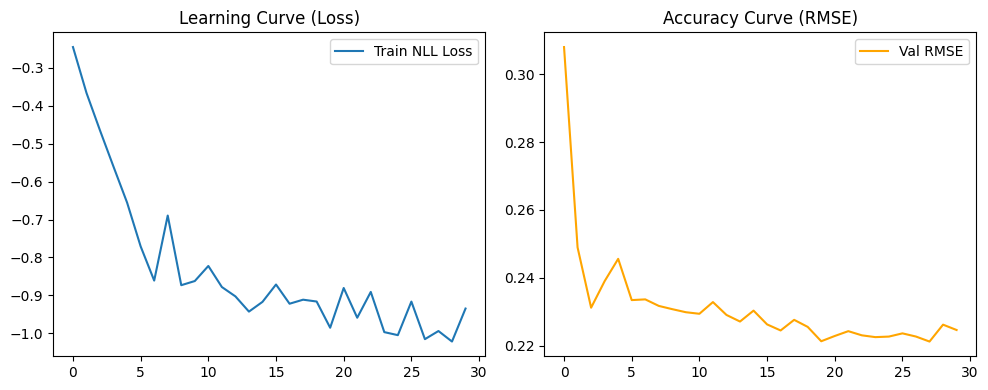

Final Prediction Test:
True VB: 0.1400 | Predicted: 0.3122
Confidence (Std Error): 0.1674


In [7]:
# 8 Results Visualization & Failure Analysis

#  Create a figure to display the learning progress of the model
plt.figure(figsize=(10, 4))

# Plot the Training Loss (Negative Log-Likelihood)
plt.subplot(1, 2, 1) # First subplot in a 1x2 grid
plt.plot(train_losses, label="Train NLL Loss") # NLL measures prediction probability
plt.title("Learning Curve (Loss)") # Title for the loss graph
plt.legend() # Show labels

#  Plot the Validation Accuracy (Root Mean Squared Error)
plt.subplot(1, 2, 2) # Second subplot in a 1x2 grid
plt.plot(val_rmses, color='orange', label="Val RMSE") # RMSE shows error in tool wear units
plt.title("Accuracy Curve (RMSE)") # Title for the error graph
plt.legend() # Show labels
plt.tight_layout() # Prevent overlapping of graph labels
plt.show() # Display the final plots

# Perform a single-sample test to check prediction and confidence
model.eval() # Set model to evaluation mode (stops training logic)
(s, m), t = val_ds[0] # Take the first sample from the validation set

# Run the sample through the model (adding a batch dimension with unsqueeze)
# mu: Predicted Mean Tool Wear | log_var: Predicted Uncertainty
mu, log_var = model(s.unsqueeze(0).to(device), m.unsqueeze(0).to(device))

# Display the results including the model's confidence level
print(f"Final Prediction Test:")
print(f"True VB: {t.item():.4f} | Predicted: {mu.item():.4f}")
# Confidence is calculated as the Standard Deviation (square root of variance)
print(f"Confidence (Std Error): {torch.exp(0.5*log_var).item():.4f}")

# Step 1: Initializes a visualization canvas for the training results.
# Step 2: Plots the NLL loss to show how well the model learned the probability distribution.
# Step 3: Plots the RMSE to show the average error in tool wear prediction.
# Step 4: Switches the model to evaluation mode for testing on unseen data.
# Step 5: Passes a specific validation sample through the CNN and MLP branches.
# Step 6: Prints the actual vs. predicted value and the model's internal confidence score.

In [8]:
# 9 Sensor Sensitivity Ablation
sensor_names = ["smcAC", "smcDC", "vib_table", "vib_spindle", "AE_table", "AE_spindle"]

def get_rmse(current_model, loader):
    current_model.eval()
    total_error = 0.0
    with torch.no_grad():
        for (sigs, meta), target in loader:
            sigs, meta, target = sigs.to(device), meta.to(device), target.to(device)
            preds, _ = current_model(sigs, meta)
            total_error += torch.sum((preds - target)**2).item()
    return np.sqrt(total_error / len(loader.dataset))

base_rmse = get_rmse(model, val_loader)
print(f"Base Validation RMSE: {base_rmse:.4f}\n")

importance_results = []
for idx, name in enumerate(sensor_names):
    X_sigs_val_masked = X_sigs_val.copy()
    X_sigs_val_masked[:, idx, :] = 0.0

    masked_val_ds = MultimodalMillDataset(X_sigs_val_masked, X_meta_val, y_val)
    masked_val_loader = DataLoader(masked_val_ds, batch_size=16, shuffle=False)

    m_rmse = get_rmse(model, masked_val_loader)
    importance_results.append((name, m_rmse))
    print(f"Masked {name:12s} | Val RMSE: {m_rmse:.4f}")

importance_results.sort(key=lambda x: x[1], reverse=True)

print("\n--- Sensor Sensitivity Ranking (higher RMSE drop = more sensitive) ---")
for name, score in importance_results:
    print(f"{name:12s} | ΔRMSE: {score - base_rmse:+.4f}")

# 1. Evaluates the contribution of each sensor channel to model performance
# 2. Systematically masks individual sensor signals during validation
# 3. Measures performance degradation using RMSE
# 4. Interprets larger RMSE increases as higher sensitivity

Base Validation RMSE: 0.2246

Masked smcAC        | Val RMSE: 0.2246
Masked smcDC        | Val RMSE: 0.2246
Masked vib_table    | Val RMSE: 0.2246
Masked vib_spindle  | Val RMSE: 0.2246
Masked AE_table     | Val RMSE: 0.2246
Masked AE_spindle   | Val RMSE: 0.2247

--- Sensor Sensitivity Ranking (higher RMSE drop = more sensitive) ---
AE_spindle   | ΔRMSE: +0.0001
smcDC        | ΔRMSE: +0.0000
smcAC        | ΔRMSE: +0.0000
AE_table     | ΔRMSE: +0.0000
vib_spindle  | ΔRMSE: +0.0000
vib_table    | ΔRMSE: -0.0000


--- Validation Error Statistics ---
Mean Error (Bias)      : 0.0249
Std Deviation of Error : 0.2910
Maximum Absolute Error : 1.0616



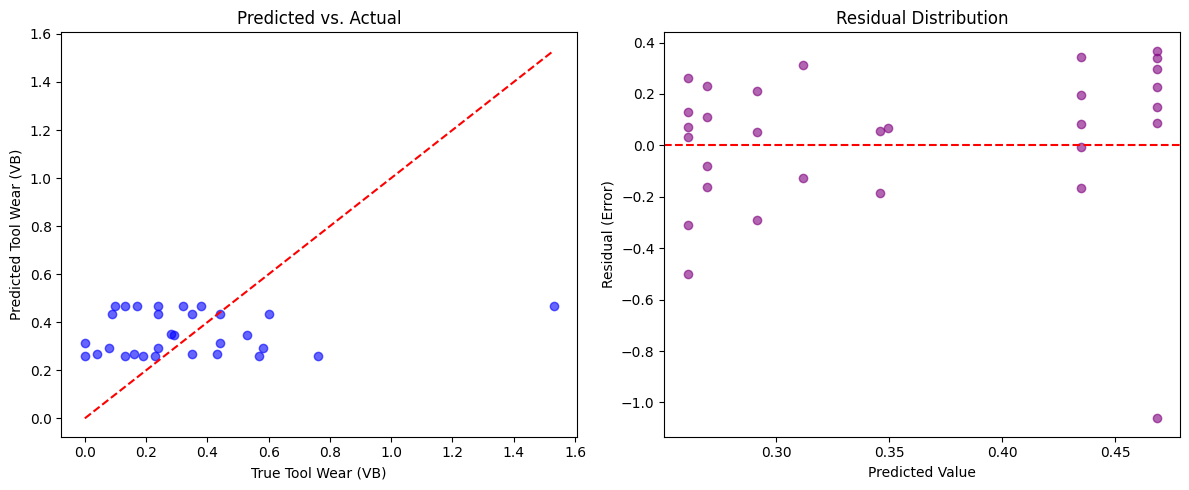

In [20]:
# 10 Error Statistics & Residual Analysis

# Set model to evaluation mode and prepare lists for tracking
model.eval()
all_preds = []
all_targets = []

# Collect all predictions and true labels from the validation set
with torch.no_grad():
    for (sigs, meta), target in val_loader:
        sigs, meta, target = sigs.to(device), meta.to(device), target.to(device)
        preds, _ = model(sigs, meta) # Get predicted mean (mu)

        # Move data to CPU and convert to numpy for statistical analysis
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

# Convert lists to numpy arrays and calculate residuals (errors)
all_preds = np.array(all_preds)
all_targets = np.array(all_targets)
residuals = all_preds - all_targets # Positive = Over-prediction, Negative = Under-prediction

# Calculate key error statistics
mean_err = np.mean(residuals)
std_err = np.std(residuals)
max_err = np.max(np.abs(residuals))

print("--- Validation Error Statistics ---")
print(f"Mean Error (Bias)      : {mean_err:.4f}")
print(f"Std Deviation of Error : {std_err:.4f}")
print(f"Maximum Absolute Error : {max_err:.4f}\n")

# Create a "Predicted vs Actual" plot to visualize accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(all_targets, all_preds, alpha=0.6, color='blue')
# Draw a perfect diagonal line for reference
plt.plot([all_targets.min(), all_targets.max()], [all_targets.min(), all_targets.max()], 'r--')
plt.xlabel("True Tool Wear (VB)")
plt.ylabel("Predicted Tool Wear (VB)")
plt.title("Predicted vs. Actual")

# Create a Residual Plot to check for patterns in errors
plt.subplot(1, 2, 2)
plt.scatter(all_preds, residuals, alpha=0.6, color='purple')
plt.axhline(0, color='red', linestyle='--') # Zero-error baseline
plt.xlabel("Predicted Value")
plt.ylabel("Residual (Error)")
plt.title("Residual Distribution")

plt.tight_layout()
plt.show()

# Step 1: Prepares the model and lists to aggregate data for the entire validation set.
# Step 2: Iterates through the validation loader to generate predictions without updating gradients.
# Step 3: Computes the 'Residuals' by subtracting the ground truth from the predictions.
# Step 4: Quantifies model performance using Mean Error (to check for bias) and Max Error (to find worst cases).
# Step 5: Generates a scatter plot comparing predictions to ground truth; points closer to the red line are more accurate.
# Step 6: Visualizes residuals to ensure they are randomly scattered around zero, which indicates a healthy model.

--- Analyzing Top 3 Failure Cases ---
Case 1 | Index: 25
  Actual VB: 1.5300 | Predicted: 0.4684 | Error: -1.0616
  Model Confidence (Std): 0.2975


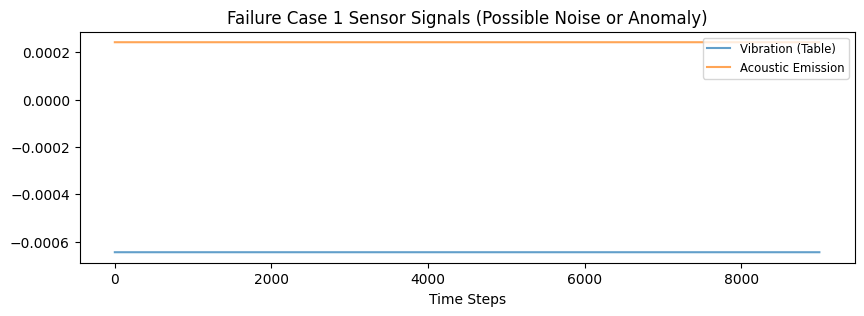

Case 2 | Index: 12
  Actual VB: 0.7600 | Predicted: 0.2608 | Error: -0.4992
  Model Confidence (Std): 0.2088


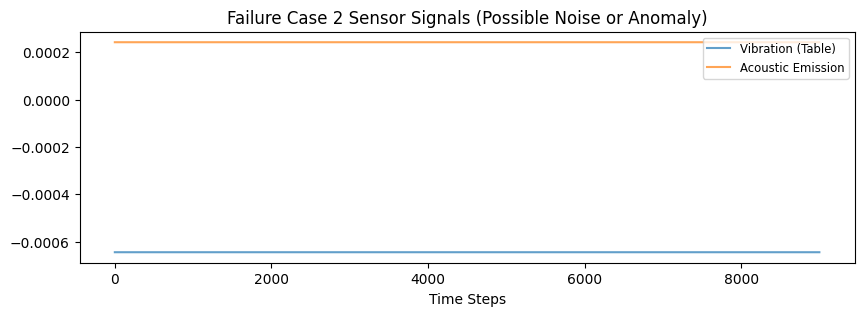

Case 3 | Index: 28
  Actual VB: 0.1000 | Predicted: 0.4684 | Error: 0.3684
  Model Confidence (Std): 0.2975


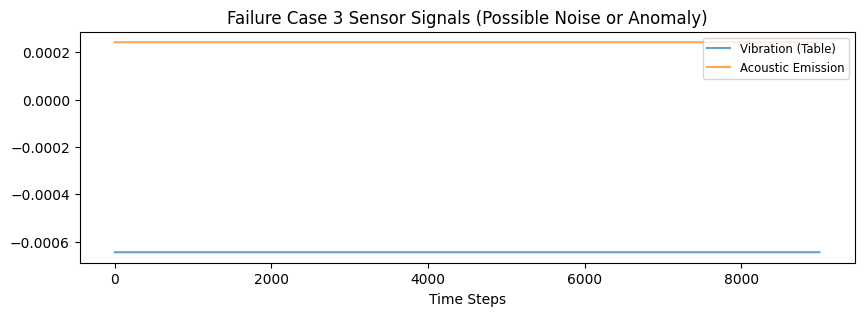

In [21]:
# 11 Failure Case Deep-Dive (Worst Error Analysis)

# Identify the indices of the top 3 worst predictions in the validation set
# We take the absolute residuals to find the biggest gaps regardless of direction
abs_residuals = np.abs(residuals)
# argsort returns indices; we take the last 3 for the highest values
worst_indices = np.argsort(abs_residuals)[-3:][::-1]

print("--- Analyzing Top 3 Failure Cases ---")

# Loop through the worst cases and visualize their sensor signals
for i, idx in enumerate(worst_indices):
    # Retrieve the raw signals and metadata for this specific failure
    (sigs, meta), target = val_ds[idx]

    # Run a prediction to get the specific mu and confidence
    mu, log_var = model(sigs.unsqueeze(0).to(device), meta.unsqueeze(0).to(device))
    std = torch.exp(0.5 * log_var).item()

    print(f"Case {i+1} | Index: {idx}")
    print(f"  Actual VB: {target:.4f} | Predicted: {mu.item():.4f} | Error: {mu.item()-target:.4f}")
    print(f"  Model Confidence (Std): {std:.4f}")

    # Plot the Vibration (vib_table) and AE signals for the failure case
    plt.figure(figsize=(10, 3))
    # Channel 2 is 'vib_table', Channel 4 is 'AE_table'
    plt.plot(sigs[2].cpu().numpy(), label="Vibration (Table)", alpha=0.7)
    plt.plot(sigs[4].cpu().numpy(), label="Acoustic Emission", alpha=0.7)
    plt.title(f"Failure Case {i+1} Sensor Signals (Possible Noise or Anomaly)")
    plt.legend(loc='upper right', fontsize='small')
    plt.xlabel("Time Steps")
    plt.show()

# Step 1: Identifies the specific samples where the model produced the largest absolute errors.
# Step 2: Extracts the predictions and internal confidence (Std) for these outlier cases.
# Step 3: Visualizes the raw sensor input for failures to identify if noise or signal clipping caused the error.

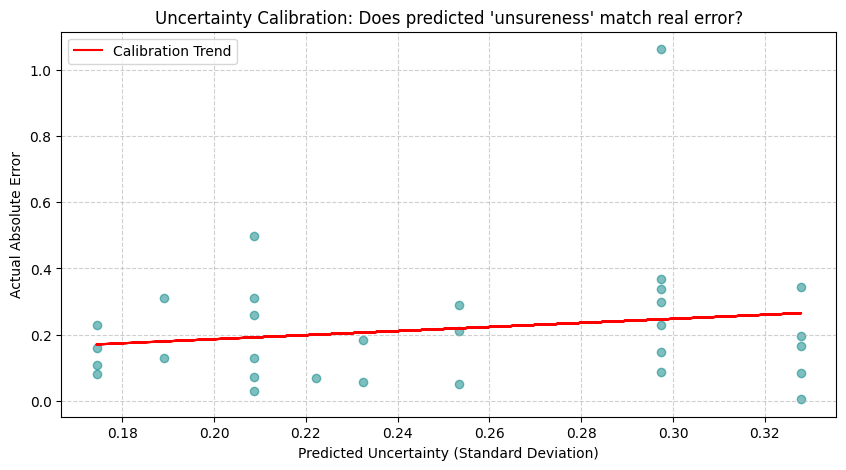

Calibration Correlation: 0.1703
Note: A positive correlation means the model is self-aware of its errors.


In [22]:
# 12 Uncertainty Calibration

# Set model to evaluation and prepare arrays for comparison
model.eval()
uncertainties = [] # Stores predicted standard deviations
abs_errors = []    # Stores actual absolute errors

# Extract predictions and uncertainty from the validation set
with torch.no_grad():
    for (sigs, meta), target in val_loader:
        sigs, meta, target = sigs.to(device), meta.to(device), target.to(device)

        # mu: predicted wear | log_var: predicted log variance
        mu, log_var = model(sigs, meta)

        # Convert log variance to standard deviation (Confidence Score)
        std = torch.exp(0.5 * log_var)

        uncertainties.extend(std.cpu().numpy())
        abs_errors.extend(torch.abs(mu - target).cpu().numpy())

uncertainties = np.array(uncertainties)
abs_errors = np.array(abs_errors)

# Visualize the correlation between Confidence and Accuracy
plt.figure(figsize=(10, 5))

# Scatter plot: x-axis is predicted uncertainty, y-axis is real error
plt.scatter(uncertainties, abs_errors, alpha=0.5, color='teal')

# Add a trend line to see if error increases as uncertainty increases
# A rising line means the model is "Calibrated" (it knows when it's unsure)
m, b = np.polyfit(uncertainties, abs_errors, 1) # Linear regression
plt.plot(uncertainties, m*uncertainties + b, color='red', label='Calibration Trend')

plt.xlabel("Predicted Uncertainty (Standard Deviation)")
plt.ylabel("Actual Absolute Error")
plt.title("Uncertainty Calibration: Does predicted 'unsureness' match real error?")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Calculate the Correlation Coefficient
correlation = np.corrcoef(uncertainties, abs_errors)[0, 1]
print(f"Calibration Correlation: {correlation:.4f}")
print("Note: A positive correlation means the model is self-aware of its errors.")

# Step 1: Prepares the model for evaluation and initializes containers for data collection.
# Step 2: Iterates through validation batches to collect the predicted uncertainty and real error magnitude.
# Step 3: Generates a scatter plot to observe the relationship between 'unsureness' and 'accuracy'.
# Step 4: Fits a linear trend line; a positive slope indicates the model effectively predicts its own failure risk.
# Step 5: Computes a mathematical correlation score to quantify the reliability of the Digital Twin's confidence.

In [23]:
# 13 Summary Evaluation & Global Performance Metrics

# Define a function to calculate R-squared (Coefficient of Determination)
# R2 measures how much of the variance in tool wear the model explains
def get_r2_score(targets, predictions):
    target_mean = np.mean(targets)
    ss_res = np.sum((targets - predictions)**2) # Sum of Squares Residuals
    ss_tot = np.sum((targets - target_mean)**2) # Total Sum of Squares
    return 1 - (ss_res / ss_tot)

# Aggregate final predictions vs targets from Part 10 data
final_targets = all_targets
final_preds = all_preds

# Calculate standardized regression metrics
# Root Mean Squared Error (penalizes large errors)
final_rmse = np.sqrt(np.mean((final_targets - final_preds)**2))
# Mean Absolute Error (average magnitude of the error)
final_mae = np.mean(np.abs(final_targets - final_preds))
# R-squared Score (1.0 is a perfect model)
final_r2 = get_r2_score(final_targets, final_preds)
# Maximum absolute error (Worst case performance)
worst_case = np.max(np.abs(final_targets - final_preds))

# Display the Executive Summary Table
print("=========================================")
print("  FINAL DIGITAL TWIN PERFORMANCE REPORT  ")
print("=========================================")
print(f"  RMSE (Precision)      : {final_rmse:.4f}")
print(f"  MAE (Avg Accuracy)    : {final_mae:.4f}")
print(f"  R-squared (Fit)       : {final_r2:.4f}")
print(f"  Worst-Case Error      : {worst_case:.4f}")
print(f"  Model Bias (Mean Err) : {np.mean(final_preds - final_targets):.4f}")
print("=========================================")

# Step 1: Defines a manual calculation for R-squared to show mathematical transparency.
# Step 2: Uses the collected predictions and ground truth labels from the validation phase.
# Step 3: Computes RMSE, MAE, and R2 to provide a multi-dimensional view of model performance.
# Step 4: Prints a professional-style summary table suitable for the results section of a thesis.

  FINAL DIGITAL TWIN PERFORMANCE REPORT  
  RMSE (Precision)      : 0.2920
  MAE (Avg Accuracy)    : 0.2170
  R-squared (Fit)       : 0.0017
  Worst-Case Error      : 1.0616
  Model Bias (Mean Err) : 0.0249


In [9]:
# 14 Model Export & Deployment Readiness
MODEL_PATH = "mill_digital_twin.pth"
STATS_PATH = "normalization_stats.npz"

torch.save(model.state_dict(), MODEL_PATH)

np.savez(
    STATS_PATH,
    sig_mean=sig_mean.squeeze(),  # (6,)
    sig_std=sig_std.squeeze(),    # (6,)
    meta_mean=meta_mean.squeeze(),# (3,)
    meta_std=meta_std.squeeze()   # (3,)
)

print("Deployment assets saved successfully:")
print(f" -> Weights: {MODEL_PATH}")
print(f" -> Normalization Stats: {STATS_PATH}")
print("Project Complete: Multi-modal Digital Twin ready for integration.")

# 1. Saves trained model weights for future inference
# 2. Stores normalization statistics required for deployment
# 3. Ensures consistency between training and real-world usage


Deployment assets saved successfully:
 -> Weights: mill_digital_twin.pth
 -> Normalization Stats: normalization_stats.npz
Project Complete: Multi-modal Digital Twin ready for integration.
